In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 23 10:59:46 2020

https://dash.plotly.com/

@author: Christo Strydom
"""
import tensorflow as tf
from tensorflow import keras
import plotly.graph_objects as go
import os
import tempfile
import datetime as datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import sklearn
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
os.chdir('/media/lnr-ai/christo/github_repos/ae_mp/')
# from sklearn.model_selection import train_test_split
# import pandas as pd
# import numpy as np
#%%
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
format_str=MP_FXCM_DATETIME_FORMAT='%Y-%m-%d %H:%M:%S'

In [2]:
%matplotlib inline

In [11]:
ae_data_path='/media/lnr-ai/christo/github_repos/ae_mp/data/'
ae_candles_filename = 'data/USDZAR_Candlestick_5_M_BID_01.01.2019-08.02.2020_wrangled.csv'
ae_df=pd.read_csv(ae_candles_filename)
ae_df=ae_df[ae_df.is_business_day].copy()
ae_df['jhb_timestamp'] =  pd.to_datetime(ae_df['jhb_timestamp'], format=format_str)
format_str='%Y-%m-%d'
ae_df['date'] =  pd.to_datetime(ae_df['date'], format=format_str)

In [4]:
def pkl_dump(df, fname, data_path):
   f = open("{data_path}{fname}.pkl".format(fname=fname,data_path=data_path),"wb")
   pickle.dump(df,f)
   f.close()
   return

def pkl_load(fname, data_path):
   return pickle.load( open( "{data_path}{fname}.pkl".format(fname=fname, data_path=data_path), "rb" ) )  

def time_filter_fn(df, start_int_seconds, end_int_seconds):
   return (ae_df['int_seconds']>=start_int_seconds) & (ae_df['int_seconds']<=end_int_seconds)

def businessday_filter_fn(df):
   return df['is_business_day']

def mp_filter_fn(df, start_int_seconds, end_int_seconds):
   time_filter=time_filter_fn(df, start_int_seconds, end_int_seconds)
   businessday_filter=businessday_filter_fn(df)
   return time_filter&businessday_filter

def days_fn(df,mp_filter):
   return list(set(df.loc[mp_filter, 'date'])) 
# days=list(set(ae_df.loc[mp_filter, 'date'])) 

def day_filter_fn(df,day):
   return df['date']==day

def range_fn(df, day_filter,time_filter):
    f=np.logical_and(day_filter, time_filter)
    on_high=max(df.loc[f, 'high'])
    on_low=min(df.loc[f, 'low'])   
    on_range=on_high-on_low
    return on_high, on_low, on_range

def on_fn(df, day_filter, on_high, on_low, on_range):
   df.loc[day_filter, 'on_low']=on_low
   df.loc[day_filter, 'on_high']=on_high
   df.loc[day_filter, 'on_range']=on_range
   return df

def order_fn(df,day_filter, perc_level, on_high, on_low, on_range):   
   df.loc[day_filter, 'sell_{perc_level}'.format(perc_level=perc_level)]=on_high+perc_level*on_range/100
   df.loc[day_filter, 'buy_{perc_level}'.format(perc_level=perc_level)]=on_low-perc_level*on_range/100
   return df

def trade_range_fn(df, day):
    day_filter=day_filter_fn(df, day)
    time_filter=time_filter_fn(df, 0, 28800)
    on_high, on_low, on_range=range_fn(df, day_filter, time_filter)
    df=on_fn(df, day_filter, on_high, on_low, on_range)
    for perc_level in [50,75,100]:
        df=order_fn(df=df,day_filter=day_filter, 
                  perc_level=perc_level, 
                  on_high=on_high, 
                  on_low=on_low, 
                  on_range=on_range)
    return df

def trade_df_fn(df, dfilter, tfilter):
    return df[np.logical_and(dfilter, tfilter)]
# on_high, on_low, on_range=range_fn(df=ae_df, day_filter=day_filter, time_filter=time_filter)

#### No need to run this cell every time:

In [ ]:
mp_filter=mp_filter_fn(df=ae_df, start_int_seconds=0, end_int_seconds=28800)
ae_df['overnight_range']=mp_filter
days = days_fn(ae_df,mp_filter)
for day in days:
   index=days.index(day)
   print('Doing day = {day} and index = {index}...'.format(index=index, day=day))
   ae_df=trade_range_fn(ae_df, day)

#### This saves the OUTPUT from the previous cell:

In [ ]:
pkl_dump(df=ae_df, fname='ae_df.csv', data_path=ae_data_path)

#### This LOADS the output from the precious TWO cells and do some preliminary work:

In [12]:
# pickle load file:
ae_df=pkl_load(fname='ae_df.csv', data_path=ae_data_path)
# make date column:
ae_df['date'] =  pd.to_datetime(ae_df['date'], format=format_str)
# Extract only business days:
ae_df=ae_df[ae_df.is_business_day].copy()
# day=max(ae_df['date'])

#### time_filter sets the slice of the day that defines the overnight range:

In [ ]:
on_high, on_low, on_range=range_fn(df=ae_df, day_filter=day_filter, time_filter=time_filter)

In [ ]:
df=on_fn(df, day_filter, on_high, on_low, on_range)

In [ ]:
for perc_level in [50,75,100]:
    df=order_fn(df=df,day_filter=day_filter, 
              perc_level=perc_level, 
              on_high=on_high, 
              on_low=on_low, 
              on_range=on_range)

In [ ]:
dst=list(df['datetime'])[-1]
# dst.year
date_object = datetime.datetime.strptime(dst, "%Y-%m-%d %H:%M:%S")

In [ ]:
datetime.datetime.strptime(dst, "%Y-%m-%d")

In [ ]:
datetime.datetime.strptime(dst, "%Y-%m-%d %H:%M:%S")

In [ ]:
date_object.year

In [ ]:
d=datetime.datetime(date_object.year, date_object.month,date_object.day, 8, 30)

In [ ]:
d.strftime("%Y-%m-%d %H:%M:%S")

In [ ]:
def time_fn(dst):
    date_object = datetime.datetime.strptime(dst, "%Y-%m-%d %H:%M:%S")
    end_d=datetime.datetime(date_object.year, date_object.month,date_object.day, 8,0)
    start_d=datetime.datetime(date_object.year, date_object.month,date_object.day, 0, 0)
    fin_d=datetime.datetime(date_object.year, date_object.month,date_object.day, 23,59,59)
    return start_d.strftime("%Y-%m-%d %H:%M:%S"), end_d.strftime("%Y-%m-%d %H:%M:%S"), fin_d.strftime("%Y-%m-%d %H:%M:%S")

In [ ]:
start_time, end_time, fin_time = time_fn(dst=list(df['datetime'])[0])

In [ ]:

# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')
df=ae_df[day_filter].copy()
min_y=min(min(df['Low']),min(df.buy_100))*0.995
max_y=max(max(df['High']),max(df.sell_100))*1.005
fig = go.Figure(data=[go.Candlestick(x=df['datetime'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
start_time, end_time, fin_time = time_fn(dst=list(df['datetime'])[0])
# fig.update_xaxes(range=[min(df.buy_100), max(df.sell_100)])
# fig.update_yaxes(range=[start_time, end_time])


# start_time=list(df['datetime'])[0]
# end_time=list(df['datetime'])[-1]

fig.update_layout(
    title='Overnight trade',
    yaxis_title='USDZAR',
    shapes = [
        dict(
#         type="rect",
        x0=end_time, x1=fin_time, y0=list(df.sell_100)[0], y1=list(df.sell_100)[0],
        line=dict(color="red",width=1,dash="dashdot"),opacity=0.2),
        dict(
        x0=end_time, x1=fin_time, y0=list(df.sell_75)[0], y1=list(df.sell_75)[0],
        line=dict(color="red",width=1,dash="dashdot"),opacity=0.3),
        dict(
        x0=end_time, x1=fin_time, y0=list(df.sell_50)[0], y1=list(df.sell_50)[0],
        line=dict(color="red",width=1,dash="dashdot"),opacity=0.4),
        dict(
        x0=end_time, x1=fin_time, y0=list(df.buy_100)[0], y1=list(df.buy_100)[0],
        line=dict(color="green",width=1,dash="dashdot"),opacity=0.2),
        dict(
        x0=end_time, x1=fin_time, y0=list(df.buy_75)[0], y1=list(df.buy_75)[0],
        line=dict(color="green",width=1,dash="dashdot"),opacity=0.3),
        dict(
        x0=end_time, x1=fin_time, y0=list(df.buy_50)[0], y1=list(df.buy_50)[0],
        line=dict(color="green",width=1,dash="dashdot"),opacity=0.4),      
        dict(
        type="rect",
        x0=start_time, x1=end_time, y0=list(df.on_low)[0], y1=list(df.on_high)[0],
        fillcolor="LightSkyBlue", opacity=0.15),
        dict(
        type="rect",
        x0=start_time, x1=end_time, y0=min_y, y1=max_y,
        fillcolor="LightSkyBlue", opacity=0.05),        
#         dict(
#         x0=start_time, x1=end_time, y0=list(df.on_low)[0], y1=list(df.on_low)[0],
#         line_width=1),
#         dict(
#         x0=start_time, x1=end_time, y0=list(df.on_high)[0], y1=list(df.on_high)[0],
#         line_width=1)
    ])

# fig.update_xaxes(range=[min(df.buy_100), max(df.sell_100)])
# fig.update_yaxes(range=[start_time, end_time])
# fig.add_shape(
#         # filled Rectangle
#             type="rect",
#             xref="x",
#             yref="y",    
#             x0=start_time,
#             y0=df.buy_100,
#             x1=end_time,
#             y1=df.sell_100,
#             line=dict(
#                 color="RoyalBlue",
#                 width=2,
#             ),
#             fillcolor="LightSkyBlue",
#         )
# fig.add_shape(
#         # Rectangle reference to the plot
#             type="rect",
#             xref="paper",
#             yref="paper",
#             x0=0.25,
#             y0=0,
#             x1=0.5,
#             y1=0.5,
#             line=dict(
#                 color="LightSeaGreen",
#                 width=3,
#             ),
#             fillcolor="PaleTurquoise",
#         )

# fig.add_shape(
#         # Line reference to the axes
#             type="line",
#             xref="x",
#             yref="y",
#             x0=4,
#             y0=0,
#             x1=8,
#             y1=1,
#             line=dict(
#                 color="LightSeaGreen",
#                 width=3,
#             ),
#         )
# fig.update_yaxes(range=[min_x, max_x])
#     shapes = [dict(
#         x0='2019-08-21 00:00:00', x1='2019-08-21 23:55:00', y0=list(df.on_high)[0], y1=list(df.on_high)[0],
#         line_width=1)],
# fig.update_layout(
#     title='The Great Recession',
#     yaxis_title='USDZAR',
# #     shapes = [dict(
# #         x0='2019-08-21 00:00:00', x1='2019-08-21 23:55:00', y0=list(df.on_low)[0], y1=list(df.on_low)[0],
# #         line_width=1)],
    
#     shapes = [dict(
#         x0='2019-08-21 00:00:00', x1='2019-08-21 23:55:00', y0=list(df.on_high)[0], y1=list(df.on_high)[0],
#         line_width=1)])
    
#     annotations=[dict(
#         x='2016-12-09', y=0.05, xref='x', yref='paper',
#         showarrow=False, xanchor='left', text='Increase Period Begins')]


fig.show()

In [ ]:
def trade_df_fn(df, dfilter, tfilter):
    return df[np.logical_and(dfilter, tfilter)]

In [ ]:
list(ae_df)

In [15]:
daylist=list(set(ae_df.date))

In [16]:
daylist

[Timestamp('2019-05-10 00:00:00'),
 Timestamp('2019-03-11 00:00:00'),
 Timestamp('2019-06-24 00:00:00'),
 Timestamp('2019-10-28 00:00:00'),
 Timestamp('2019-10-07 00:00:00'),
 Timestamp('2019-11-28 00:00:00'),
 Timestamp('2019-08-20 00:00:00'),
 Timestamp('2019-07-19 00:00:00'),
 Timestamp('2019-11-14 00:00:00'),
 Timestamp('2019-11-15 00:00:00'),
 Timestamp('2019-01-21 00:00:00'),
 Timestamp('2019-11-21 00:00:00'),
 Timestamp('2019-10-11 00:00:00'),
 Timestamp('2019-12-10 00:00:00'),
 Timestamp('2019-07-08 00:00:00'),
 Timestamp('2019-02-11 00:00:00'),
 Timestamp('2019-01-15 00:00:00'),
 Timestamp('2019-03-25 00:00:00'),
 Timestamp('2019-12-23 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-09-12 00:00:00'),
 Timestamp('2019-04-15 00:00:00'),
 Timestamp('2019-09-27 00:00:00'),
 Timestamp('2019-12-26 00:00:00'),
 Timestamp('2019-11-22 00:00:00'),
 Timestamp('2020-01-21 00:00:00'),
 Timestamp('2019-10-29 00:00:00'),
 Timestamp('2019-03-27 00:00:00'),
 Timestamp('2019-10-

In [8]:
list(ae_df)

['datetime',
 'date',
 'Gmt time',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'bidopen',
 'bidclose',
 'bidhigh',
 'bidlow',
 'askopen',
 'askclose',
 'askhigh',
 'asklow',
 'tickqty',
 'open',
 'high',
 'low',
 'close',
 'period',
 'dom',
 'awdn',
 'month',
 'doy',
 'wny',
 'timestamp',
 'ny_timestamp',
 'london_timestamp',
 'jhb_timestamp',
 'int_seconds',
 'universaldate',
 'is_business_day',
 'previous_business_day',
 'five_previous_business_day']

In [41]:
day=daylist[2]


In [54]:
tfilter=time_filter_fn(ae_df.copy(), 28800, 24*60*60)
ae_df['MTM']=0
if 'mtm' in list(ae_df):
    ae_df.drop('mtm',axis=1,inplace=True)
for day in daylist:
    print('------------------------------------------------------------------------------------------------')
    print('doing ', day, ' which is index=',daylist.index(day))
    day_filter=day_filter_fn(ae_df, day)
    trade_df=trade_df_fn(df=ae_df.copy(), dfilter=day_filter, tfilter=tfilter)
    trade_df['mtm']=0
    trade_df['pos']=0
    trade_df['trade']=0
    trade_df['entry_price']=0
    strade_dict=dict()
    spos=0
    trade_df_maxindex=max(trade_df.index)
    for index, (trade_df_index,dt,close,sell_50,sell_75,sell_100) in enumerate(zip(trade_df.index,trade_df['datetime'],trade_df['Close'], trade_df['sell_50'],trade_df['sell_75'],trade_df['sell_100'])):
#         print(index,close,dt)
        if (close>sell_50) and (trade_df.loc[trade_df_index-1,'pos']==0):
    #         spos+=1
    #         trade_df.loc[range(trade_df_index,trade_df_maxindex+1),'spos']=spos
            trade_df.loc[trade_df_index,'trade']=-1
            trade_df.loc[trade_df_index,'entry_price']=close
            average_entry_price=trade_df['trade']
        if (close>sell_75) and (trade_df.loc[trade_df_index-1,'pos']==-1):
            spos+=1                
    #         trade_df.loc[range(trade_df_index,trade_df_maxindex+1),'spos']=spos
            trade_df.loc[trade_df_index,'trade']=-1
            trade_df.loc[trade_df_index,'entry_price']=close    
        if (close>sell_100) and (trade_df.loc[trade_df_index-1,'pos']==-2):
            spos+=1                
    #         trade_df.loc[range(trade_df_index,trade_df_maxindex+1),'spos']=spos
            trade_df.loc[trade_df_index,'trade']=-1
            trade_df.loc[trade_df_index,'entry_price']=close    
        trade_df['pos']=trade_df['trade'].cumsum()
        trade_df.loc[trade_df_index,'mtm']=sum(trade_df['trade'].values*close- np.multiply(trade_df['trade'], trade_df['entry_price']))

    if 'mtm' in list(ae_df):
        ae_df.drop('mtm',axis=1,inplace=True)
    # ae_df.drop('mtm_y',axis=1,inplace=True)
    ae_df=ae_df.merge(trade_df[['datetime','mtm']], left_on='datetime', right_on='datetime', how='outer')
    ae_df['mtm'].fillna(0,inplace=True)
    ae_df['MTM'] = ae_df['mtm'] + ae_df['MTM']
    ae_df.drop('mtm',axis=1,inplace=True)
    # ae_df.drop('mtm_y',axis=1,inplace=True)

------------------------------------------------------------------------------------------------
doing  2019-05-10 00:00:00  which is index= 0
------------------------------------------------------------------------------------------------
doing  2019-03-11 00:00:00  which is index= 1
------------------------------------------------------------------------------------------------
doing  2019-06-24 00:00:00  which is index= 2
------------------------------------------------------------------------------------------------
doing  2019-10-28 00:00:00  which is index= 3
------------------------------------------------------------------------------------------------
doing  2019-10-07 00:00:00  which is index= 4
------------------------------------------------------------------------------------------------
doing  2019-11-28 00:00:00  which is index= 5
------------------------------------------------------------------------------------------------
doing  2019-08-20 00:00:00  which is index= 6

------------------------------------------------------------------------------------------------
doing  2019-07-09 00:00:00  which is index= 57
------------------------------------------------------------------------------------------------
doing  2019-02-15 00:00:00  which is index= 58
------------------------------------------------------------------------------------------------
doing  2019-08-13 00:00:00  which is index= 59
------------------------------------------------------------------------------------------------
doing  2019-09-09 00:00:00  which is index= 60
------------------------------------------------------------------------------------------------
doing  2019-02-20 00:00:00  which is index= 61
------------------------------------------------------------------------------------------------
doing  2019-07-17 00:00:00  which is index= 62
------------------------------------------------------------------------------------------------
doing  2019-10-03 00:00:00  which is in

------------------------------------------------------------------------------------------------
doing  2019-01-25 00:00:00  which is index= 114
------------------------------------------------------------------------------------------------
doing  2019-04-16 00:00:00  which is index= 115
------------------------------------------------------------------------------------------------
doing  2019-04-24 00:00:00  which is index= 116
------------------------------------------------------------------------------------------------
doing  2019-05-28 00:00:00  which is index= 117
------------------------------------------------------------------------------------------------
doing  2019-07-26 00:00:00  which is index= 118
------------------------------------------------------------------------------------------------
doing  2020-01-09 00:00:00  which is index= 119
------------------------------------------------------------------------------------------------
doing  2019-01-24 00:00:00  which

------------------------------------------------------------------------------------------------
doing  2019-04-03 00:00:00  which is index= 171
------------------------------------------------------------------------------------------------
doing  2020-02-04 00:00:00  which is index= 172
------------------------------------------------------------------------------------------------
doing  2019-04-04 00:00:00  which is index= 173
------------------------------------------------------------------------------------------------
doing  2019-06-17 00:00:00  which is index= 174
------------------------------------------------------------------------------------------------
doing  2019-12-20 00:00:00  which is index= 175
------------------------------------------------------------------------------------------------
doing  2019-02-13 00:00:00  which is index= 176
------------------------------------------------------------------------------------------------
doing  2019-05-06 00:00:00  which

------------------------------------------------------------------------------------------------
doing  2019-04-22 00:00:00  which is index= 228
------------------------------------------------------------------------------------------------
doing  2019-04-10 00:00:00  which is index= 229
------------------------------------------------------------------------------------------------
doing  2019-11-12 00:00:00  which is index= 230
------------------------------------------------------------------------------------------------
doing  2019-05-15 00:00:00  which is index= 231
------------------------------------------------------------------------------------------------
doing  2019-02-14 00:00:00  which is index= 232
------------------------------------------------------------------------------------------------
doing  2019-05-03 00:00:00  which is index= 233
------------------------------------------------------------------------------------------------
doing  2019-01-10 00:00:00  which

------------------------------------------------------------------------------------------------
doing  2019-09-02 00:00:00  which is index= 285
------------------------------------------------------------------------------------------------
doing  2019-06-20 00:00:00  which is index= 286
------------------------------------------------------------------------------------------------
doing  2019-08-22 00:00:00  which is index= 287
------------------------------------------------------------------------------------------------
doing  2019-01-01 00:00:00  which is index= 288


In [52]:
trade_df.mtm

96     0.0000
97     0.0000
98     0.0000
99     0.0000
100    0.0000
        ...  
283   -0.0006
284    0.0033
285    0.0033
286   -0.0180
287   -0.0249
Name: mtm, Length: 192, dtype: float64

In [44]:
if 'mtm' in list(ae_df):
    ae_df.drop('mtm',axis=1,inplace=True)
# ae_df.drop('mtm_y',axis=1,inplace=True)
ae_df=ae_df.merge(trade_df[['datetime','mtm']], left_on='datetime', right_on='datetime', how='outer')
ae_df['MTM'] = ae_df['mtm'] + ae_df['MTM']
ae_df.drop('mtm',axis=1,inplace=True)
# ae_df.drop('mtm_y',axis=1,inplace=True)

In [53]:
ae_df[['int_seconds','MTM']]

,int_seconds,MTM
0,0,NaN
1,300,NaN
2,600,NaN
3,900,NaN
4,1200,NaN
...,...,...
82881,84900,NaN
82882,85200,NaN
82883,85500,NaN
82884,85800,NaN


In [56]:
mtm_df=ae_df[['int_seconds','MTM']].groupby(['int_seconds']).sum()

In [58]:
mtm_df.reset_index(inplace=True)

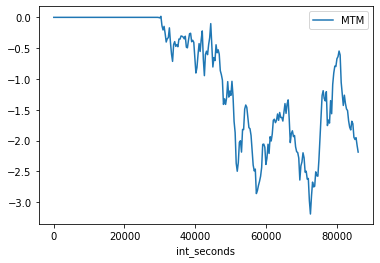

In [59]:
import matplotlib.pyplot as plt
# import pandas as pd

# gca stands for 'get current axis'
ax = plt.gca()

mtm_df.plot(kind='line',x='int_seconds',y='MTM',ax=ax)

In [61]:
profile_df=ae_df.pivot(index='int_seconds', columns='date', values='MTM')

In [76]:
tl=profile_df[profile_df.index==12*60*60].values[0]

In [77]:
np.where(profile_df[profile_df.index==12*60*60]<0)[1]

array([  1,  29,  31,  47,  58,  61,  72,  86, 110, 143, 158, 161, 200,
       215, 217, 242, 245, 280, 283])

In [78]:
tl[0]

0.0

In [81]:
len(tl[np.where(profile_df[profile_df.index==12*60*60]<0)[1]])

19

In [82]:
len(tl[np.where(profile_df[profile_df.index==12*60*60]>0)[1]])

31

In [ ]:
trade_df['entry_price']=0
trade_df.loc[trade_df['trade']!=0,'entry_price']=trade_df[trade_df['trade']!=0]['close']

In [ ]:
trade_df_index

In [ ]:
np.dot(trade_df['trade'], trade_df['entry_price'])/trade_df['pos'].values[-1]

In [ ]:
trade_df['pos'].values[-1]

In [ ]:
close

In [ ]:
(np.dot(trade_df['trade'], trade_df['entry_price'])/trade_df['pos'].values[-1]-close)*trade_df['pos'].values[-1]

In [ ]:
trade_df['trade']*-1

In [ ]:
sum(trade_df['trade'].values*close- np.multiply(trade_df['trade'], trade_df['entry_price']))

In [ ]:
trade_df['mtm']

In [ ]:

min_y=min(min(trade_df['Low']),min(trade_df.buy_100))*0.995
max_y=max(max(trade_df['High']),max(trade_df.sell_100))*1.005

fig = make_subplots(specs=[[{"secondary_y": True}]])#this a one cell subplot
trace1 = go.Scatter(x=trade_df['datetime'], 
                    y=trade_df['mtm'], 
                    marker= dict(line= dict(width= 1), 
                           size= 8), 
                    line=dict(color= '#ffc0cb', width= 1.5),
                    name= '')


fig.add_trace(go.Candlestick(x=trade_df['datetime'],
                open=trade_df['Open'],
                high=trade_df['High'],
                low=trade_df['Low'],
                close=trade_df['Close'],name= 'Candles'))
# fig.add_trace(go.Scatter(x=[start_time, end_time, fin_time], y=[1, 3, 2]),secondary_y=True)

# fig = go.Figure(data=[go.Candlestick(x=trade_df['datetime'],
#                 open=trade_df['Open'],
#                 high=trade_df['High'],
#                 low=trade_df['Low'],
#                 close=trade_df['Close'])])
# fig.add_trace(go.Bar(x=[1, 2, 3], y=[1, 3, 2]),secondary_y=True)
# start_time, end_time, fin_time = time_fn(dst=list(trade_df['datetime'])[0])
# fig.update_xaxes(range=[min(df.buy_100), max(df.sell_100)])
# fig.update_yaxes(range=[start_time, end_time])


# start_time=list(df['datetime'])[0]
# end_time=list(df['datetime'])[-1]

fig.update_layout(
    title='Overnight trade',
    yaxis_title='USDZAR',
    shapes = [
        dict(
#         type="rect",
        x0=end_time, x1=fin_time, y0=list(trade_df.sell_100)[0], y1=list(trade_df.sell_100)[0],
        line=dict(color="red",width=1,dash="dashdot"),opacity=0.2),
        dict(
        x0=end_time, x1=fin_time, y0=list(trade_df.sell_75)[0], y1=list(trade_df.sell_75)[0],
        line=dict(color="red",width=1,dash="dashdot"),opacity=0.3),
        dict(
        x0=end_time, x1=fin_time, y0=list(trade_df.sell_50)[0], y1=list(trade_df.sell_50)[0],
        line=dict(color="red",width=1,dash="dashdot"),opacity=0.4),
        dict(
        x0=end_time, x1=fin_time, y0=list(trade_df.buy_100)[0], y1=list(trade_df.buy_100)[0],
        line=dict(color="green",width=1,dash="dashdot"),opacity=0.2),
        dict(
        x0=end_time, x1=fin_time, y0=list(trade_df.buy_75)[0], y1=list(trade_df.buy_75)[0],
        line=dict(color="green",width=1,dash="dashdot"),opacity=0.3),
        dict(
        x0=end_time, x1=fin_time, y0=list(trade_df.buy_50)[0], y1=list(trade_df.buy_50)[0],
        line=dict(color="green",width=1,dash="dashdot"),opacity=0.4),      
        dict(
        type="rect",
        x0=start_time, x1=end_time, y0=list(trade_df.on_low)[0], y1=list(trade_df.on_high)[0],
        fillcolor="LightSkyBlue", opacity=0.15),
        dict(
        type="rect",
        x0=start_time, x1=end_time, y0=min_y, y1=max_y,
        fillcolor="LightSkyBlue", opacity=0.05),        
#         dict(
#         x0=start_time, x1=end_time, y0=list(df.on_low)[0], y1=list(df.on_low)[0],
#         line_width=1),
#         dict(
#         x0=start_time, x1=end_time, y0=list(df.on_high)[0], y1=list(df.on_high)[0],
#         line_width=1)
    ])

trace2 = go.Scatter(x=trade_df['datetime'], 
                    y=trade_df['mtm'], 
                    marker= dict(line= dict(width= 1), 
                           size= 8), 
                    line=dict(color= '#ffc0cb', width= 1.5),
                    name= 'MTM')
fig.add_trace(trace2, secondary_y=True);

fig.show()

In [ ]:
# import plotly.graph_objects as go
# fig = go.Figure()

from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])#this a one cell subplot
fig.add_trace(go.Candlestick(x=trade_df['datetime'],
                open=trade_df['Open'],
                high=trade_df['High'],
                low=trade_df['Low'],
                close=trade_df['Close']))
fig.add_trace(go.Scatter(x=[start_time, end_time, fin_time], y=[1, 3, 2]),secondary_y=True)
# fig.add_trace(go.Bar(x=[1, 2, 3], y=[1, 3, 2]))
fig.show()


In [ ]:
import pandas as pd
import zipfile

In [ ]:
zf = zipfile.ZipFile('/media/lnr-ai/christo/github_repos/graphing/data/clientswipes_201701_01.zip') 
df = pd.read_csv(zf.open('clientswipes_201701_01.csv'))